In [1]:
pwd

'C:\\ephys_file_manager'

In [2]:
import importlib
import neuroanalysis
importlib.reload(neuroanalysis)
from neuroanalysis.miesnwb import MiesNwb
from neuroanalysis.data.loaders.mies_dataset_loader import MiesNwbLoader
from neuroanalysis.data.dataset import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from stimset_builder import *
from pathlib import Path
import pickle

c:\neuroanalysis\neuroanalysis\util\jit.py:25: UserWarning: Could not import numba; falling back to slower implementation.
  warnings.warn("Could not import numba; falling back to slower implementation.")


In [3]:
ps_log_name = 'C:/Data/2024-01-25-000/slice-000/photostim_log.json'
with open(ps_log_name) as json_file:
    exp_ps_dict = json.load(json_file)

exp_ps_dict.keys()

dict_keys(['photostim_2', 'photostim_3', 'photostim_4', 'photostim_5'])

In [4]:
V_per_uW = 0.111621/10
uW_per_V = 1./V_per_uW

In [5]:
def get_photostim_sweeps_arc(ps_log_name, photostim_i):
    '''return a list of SyncRecordings corresponding to the indicated photostim'''
    with open(ps_log_name) as json_file:
        full_ps_dict = json.load(json_file)
    ps_dict = full_ps_dict[photostim_i]
    nwb_base_dir = 'C:/MiesSave/'
    nwb_filename = nwb_base_dir+ps_dict['mies_name']+'.nwb'
    sweeps = ps_dict['sweep']
    dataset = Dataset(loader=MiesNwbLoader(nwb_filename))
    SyncRec_list = [dataset.contents[i] for i in sweeps]
    return SyncRec_list, ps_dict

def get_photostim_dict(ps_log_name, photostim_i):
    '''return as a dictionary photostim_i from ps_log_name json file'''
    with open(ps_log_name) as json_file:
        full_ps_dict = json.load(json_file)
    ps_dict = full_ps_dict[photostim_i]
    return ps_dict

def get_photostim_sweeps(ps_dict):
    '''return a list of SyncRecordings corresponding referenced in the ps_dict'''
    nwb_base_dir = 'C:/MiesSave/'
    nwb_filename = nwb_base_dir+ps_dict['mies_name']+'.nwb'
    sweeps = ps_dict['sweep']
    dataset = Dataset(loader=MiesNwbLoader(nwb_filename))
    SyncRec_list = [dataset.contents[i] for i in sweeps]
    return SyncRec_list

In [6]:
## from collections import defaultdict
def filter_sweeps_by_stimulus(dataset, stimulus_names, devs=[0,1]):
    recording_dict = defaultdict(list)
    for sweep in dataset.contents:
        devices = sweep.devices
        for dev in devices:
            if dev in devs:
                rec = sweep[dev]
                stim_name = rec.stimulus.description
                if stim_name in stimulus_names:
                    recording_dict[stim_name].append(rec)
    return recording_dict

def features_of_stim_epoch(stimulus, description='Epoch 1'):
    feature_list = ['start_time', 'duration', 'amplitude', 'type']
    for item in stimulus.items:
        if item.description == description:
            feature_dict = {}
            for feat in feature_list:
                feature_dict[feat] = getattr(item, feat)
    return feature_dict

In [13]:
from scipy.stats import linregress
from scipy.optimize import curve_fit

def find_edges(TSeries, threshold, edge='rising'):
    y = TSeries.data
    t = TSeries.time_values
    assert edge in ['rising', 'falling'], f"value of {edge} invalid for edge argument"
    if edge == 'rising':
        edges = np.flatnonzero((y[:-1] < threshold) & (y[1:] > threshold))+1
    elif edge == 'falling':
        edges = np.flatnonzero((y[:-1] > threshold) & (y[1:] < threshold))+1
    return t[edges]

def exp_decay(x, a, tau, y0, x0):
    return a*np.exp(-(x-x0)/tau)+y0

def curve_fit_r2(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

def get_response_time_window(TSeries, start=0, dur=1, ss_window=0.05):
    '''get steady state mean, peak, trough, time of peak and trough from time slice'''
    
    time_slice = TSeries.time_slice(start, start+dur)
    mean = np.mean(time_slice.data)
    steady_state = np.mean(TSeries.time_slice(start+dur-ss_window, start+dur).data)
    peak = np.max(time_slice.data)
    peak_t = time_slice.time_values[np.argmax(time_slice.data)]
    trough = np.min(time_slice.data)
    trough_t = time_slice.time_values[np.argmin(time_slice.data)]
    response_dict = {'mean':mean,
           'steady_state':steady_state,
           'peak':peak,
           'peak_t':peak_t,
           'trough':trough,
           'trough_t':trough_t}
    return response_dict

def measure_ps_responses(SyncRecording, ps_dict):
    resp_lag = ps_dict['t1']/1e6 ##shutter lag to allow mirror movement, convert us to s
    
    
    shutter_TTL_times = find_edges(SyncRecording['Polygon Driver']['reporter'], 0.5)
    resp_duration = 0.01
    shutter_TTL_times += resp_lag ##add shutter lag
    photostim_ids = ps_dict['order']
    n_pulses = len(shutter_TTL_times)
    n_photostim = len(photostim_ids)
    resp_df = pd.DataFrame({'photostim_id':photostim_ids,
                            'photostim_t':shutter_TTL_times})
    measured_channels = []
    if n_pulses != n_photostim:
        print (f"warning: Found {n_pulses} TTL pulses. Does not match number of photostimuli ({n_photostim}).")
    
    for rec in SyncRecording.children:
        dict_list = []
        if rec.device_id not in ['Polygon Driver', 'Polygon400']:
            if rec.device_type == 'MultiClamp 700':
                trace = rec['primary']
                d_name = "HS"+str(rec.device_id)
            else: 
                trace = rec['reporter']
                d_name = rec.device_id
            for t in shutter_TTL_times:
                resp_wind_dict = get_response_time_window(trace, start=t, 
                                                          dur=resp_duration, 
                                                          ss_window=resp_duration/2)
                dict_list.append(resp_wind_dict)
            measured_channels.append(d_name)
            rec_df = pd.DataFrame(dict_list).add_prefix(d_name+"_")
            resp_df = resp_df.join(rec_df)
    ps_dict['response_df'] = resp_df
    ps_dict['measured_channels'] = measured_channels
    return ps_dict

def clean_ax(ax):
    ax.axes.xaxis.set_visible(False)
    ax.spines[['right','top','bottom']].set_visible(False)
    
def plot_SyncRecording(SR):
    
    fig = plt.figure()
    HS_recs = []
    acc_recs = []
    for dev in SR.devices:
        rec = SR[dev]
        if rec.device_type == 'MultiClamp 700':
            HS_recs.append(rec)
        else:
            if rec.device_id != 'Polygon400':
                acc_recs.append(rec)
    n_HS = len(HS_recs)
    n_acc = len(acc_recs)
    n_total = n_HS + n_acc
    i=1
    for rec in HS_recs:
        response = rec['primary'].data
        t = rec['primary'].time_values
        if i == 1:
            ax = fig.add_subplot(n_total, 1, i)
        else:
            ax = fig.add_subplot(n_total, 1, i, sharex = ax)
        ax.plot(t, response)
        if rec.clamp_mode == 'ic':
            unit = 'V'
        elif rec.clamp_mode == 'vc':
            unit = 'A'
        else:
            unit = ''
        ax.set_ylabel(f"HS{rec.device_id} {unit}")
        if i != n_total:
            clean_ax(ax)
        i+=1
    for rec in acc_recs:
        response = rec['reporter'].data
        t = rec['reporter'].time_values
        ax = fig.add_subplot(n_total, 1, i, sharex = ax)
        ax.plot(t, response)
        if i != n_total:
            clean_ax(ax)
        else:
            ax.spines[['right', 'top']].set_visible(False)
            ax.set_xlabel('time (s)')
        ax.set_ylabel(f"{rec.device_id}")
        i+=1

def find_StimSequences(directory = 'C:/stimset_building/'):
    files = [x.stem for x in Path(directory).glob('*pickle') if x.is_file()]
    return files


def load_stim_sequence_file(filename):
    with open(filename, 'rb') as file:
        stim_sequence_set = pickle.load(file)
        return stim_sequence_set
def load_ss_file_from_ps_dict(ps_dict):
    base_dir = 'C:/stimset_building/'
    filename = base_dir+ps_dict['sequence_name']+'.pickle'
    stim_sequence = load_stim_sequence_file(filename)
    return stim_sequence
    

In [14]:
ps_log_name = 'C:/Data/2024-01-25-000/slice-000/photostim_log.json'
ps_dict = get_photostim_dict(ps_log_name, 'photostim_3')
photostim_sweeps = get_photostim_sweeps(ps_dict)
ps_sweep = photostim_sweeps[0]

ps_dict = measure_ps_responses(ps_sweep, ps_dict)
sweep_df = ps_dict['response_df']
sweep_df.head()

,photostim_id,photostim_t,HS0_mean,HS0_steady_state,HS0_peak,HS0_peak_t,HS0_trough,HS0_trough_t,AD7_mean,AD7_steady_state,AD7_peak,AD7_peak_t,AD7_trough,AD7_trough_t
0,0,0.54332,2.425186e-12,2.401505e-12,4.977361e-11,0.5434,-2.850455e-11,0.54344,0.122692,0.124470,0.138357,0.54360,0.003837,0.54332
1,1,0.64332,2.425186e-12,2.622526e-12,6.292960e-11,0.6434,-3.113575e-11,0.64344,0.113039,0.114555,0.125201,0.64360,0.000877,0.64332
2,2,0.74332,2.648838e-12,2.759348e-12,5.898280e-11,0.7434,-3.968715e-11,0.74344,0.115864,0.117352,0.129477,0.74356,-0.000438,0.74336
3,3,0.84332,1.585834e-12,1.312189e-12,5.043141e-11,0.8434,-3.837155e-11,0.84344,0.117083,0.118789,0.131779,0.84360,-0.004714,0.84336
4,4,0.94332,2.643576e-12,2.764611e-12,4.253781e-11,0.9434,-4.166055e-11,0.94344,0.118464,0.119873,0.135397,0.94356,0.000548,0.94336


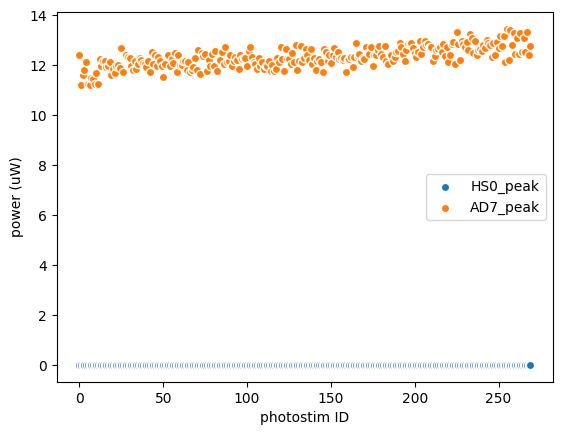

In [15]:
resp_df = ps_dict['response_df']
for ch in ps_dict['measured_channels']:
    col_name = ch+"_peak"
    y = sweep_df[col_name]*uW_per_V
    plt.scatter(sweep_df['photostim_id'], y, marker='o', edgecolors='white', label=col_name)
    plt.xlabel('photostim ID')
plt.ylabel('power (uW)')
plt.legend()
#plt.ylim([0, np.max(y)*1.1])

<IPython.core.display.Javascript object>


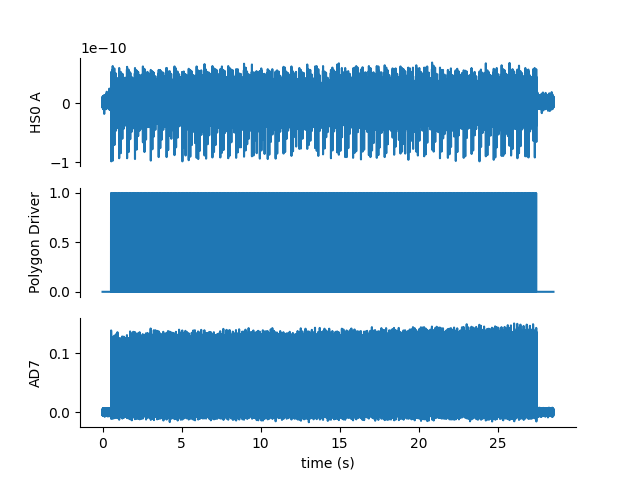

In [16]:
%matplotlib notebook
#from ipywidgets import *
plot_SyncRecording(ps_sweep)

In [17]:

stim_sequence = load_ss_file_from_ps_dict(ps_dict)

<IPython.core.display.Javascript object>


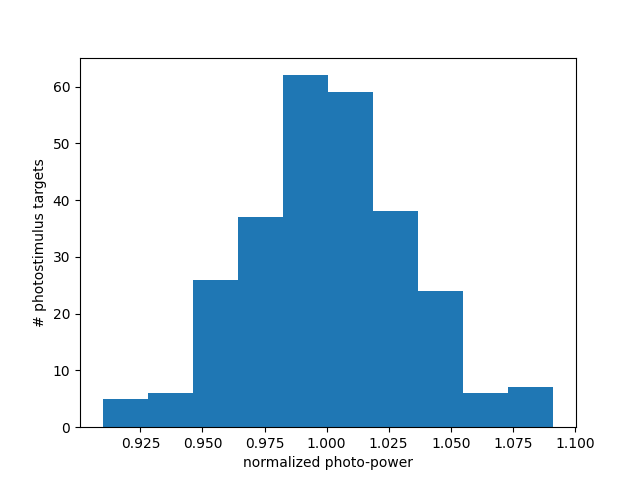

Text(0, 0.5, '# photostimulus targets')

In [20]:
plt.hist(y/np.mean(y))
plt.xlabel('normalized photo-power')
plt.ylabel('# photostimulus targets')

<IPython.core.display.Javascript object>


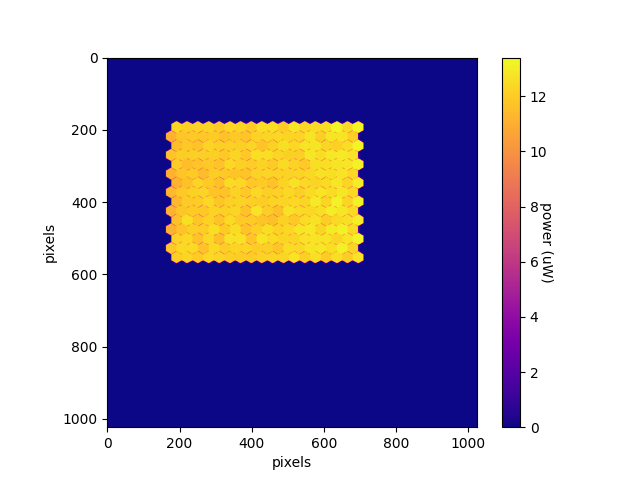

In [21]:
sum_img = np.zeros(stim_sequence.image_shape)
i = 0
for resp in y:
    img = stim_sequence.image_sequence[:,:,i] * resp/256
    sum_img+=img
    i += 1
cm = plt.imshow(sum_img, cmap='plasma', vmin=0)
cb = plt.colorbar(cm)
plt.xlabel('pixels')
plt.ylabel('pixels')
cb.set_label('power (uW)', rotation=270)
plt.show()

<IPython.core.display.Javascript object>


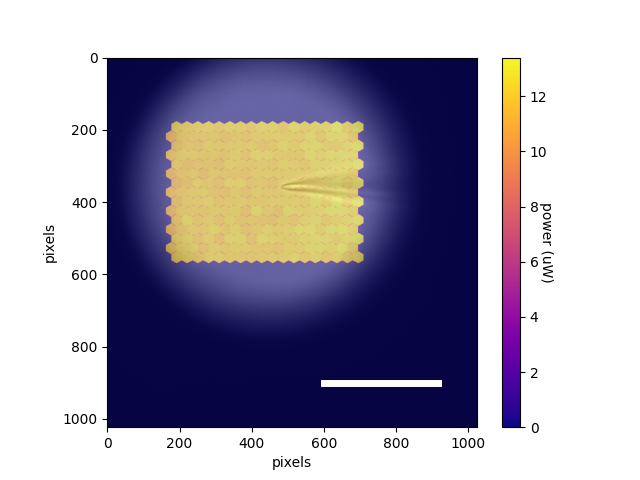

In [22]:
from tifffile import imread
pip_img_path = "C:/Data/2024-01-25-000/slice-000/img_1706309991.tif"
um_per_pix = 0.3159557662
scale_length = 100
pix_scale_l = scale_length/um_per_pix
plt.plot([600,600+pix_scale_l], [900,900], c='white', lw=5)
pip_image = imread(pip_img_path)
cm = plt.imshow(sum_img, cmap='plasma', vmin=0,alpha=1)
plt.imshow(pip_image,cmap=plt.cm.gray, alpha=0.5)

cb = plt.colorbar(cm)
plt.xlabel('pixels')
plt.ylabel('pixels')
cb.set_label('power (uW)', rotation=270)
plt.show()

In [23]:
ps_log_name = 'C:/Data/2024-01-31-000/slice-000/photostim_log.json'

with open(ps_log_name) as json_file:
    exp_ps_dict = json.load(json_file)

exp_ps_dict.keys()

dict_keys(['photostim_0', 'photostim_1', 'photostim_2', 'photostim_3', 'photostim_4', 'photostim_5', 'photostim_6', 'photostim_7', 'photostim_8', 'photostim_9', 'photostim_10', 'photostim_11'])

In [24]:

#out_array[0,:] = np.arange(8)
#out_array

In [26]:
out_array = np.zeros((122, 12))
i2_values = []
i = 0
for ps_i in exp_ps_dict.keys():
    ps_dict = get_photostim_dict(ps_log_name, ps_i)
    photostim_sweeps = get_photostim_sweeps(ps_dict)
    ps_sweep = photostim_sweeps[0]
    ps_dict = measure_ps_responses(ps_sweep, ps_dict)
    i2_values.append(ps_dict["i2"])
    resp_df = ps_dict['response_df']
    col_name = 'AD7_peak'
    peak_vs_photo_id = resp_df[col_name]
    out_array[2:,i] = peak_vs_photo_id
    i+=1
out_array[1,:] = i2_values    
    
    
    

In [27]:
out_array 

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+01, 2.00000000e+01, 2.00000000e+01, ...,
        1.50000000e+02, 1.25000000e+02, 1.00000000e+02],
       [2.13479926e-03, 1.14810211e-03, 6.41048653e-03, ...,
        9.94889215e-02, 8.20572674e-02, 6.46256134e-02],
       ...,
       [1.47700112e-03, 1.80590013e-03, 8.05498194e-03, ...,
        1.04422405e-01, 8.56751576e-02, 6.69279099e-02],
       [1.47700112e-03, 1.14810211e-03, 7.39718368e-03, ...,
        1.01462312e-01, 8.37017596e-02, 6.52834177e-02],
       [1.47700112e-03, 1.80590013e-03, 7.39718368e-03, ...,
        9.98178199e-02, 8.27150643e-02, 6.65990114e-02]])

<IPython.core.display.Javascript object>


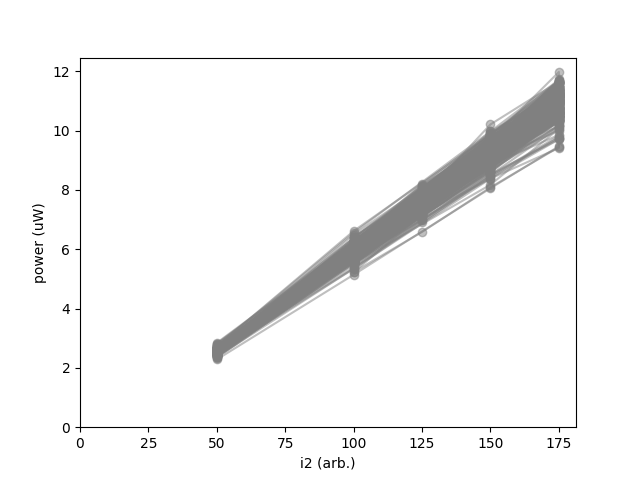

(0.0, 12.46224411299905)

In [28]:
for ps_id in range(2, 122):
    y = out_array[ps_id,:][4:]*uW_per_V
    x = out_array[1,:][4:]
    plt.plot(x,y, marker = 'o', c='grey', alpha=0.5)
plt.xlabel('i2 (arb.)')
plt.ylabel('power (uW)')
xlim = plt.xlim()
ylim = plt.ylim()
plt.xlim([0, xlim[1]])
plt.ylim([0, ylim[1]])

In [59]:
y

array([0.001477  , 0.0018059 , 0.00739718, 0.14981048, 0.02976232,
       0.06923021, 0.10869809, 0.12711644])

In [60]:
x

array([ 20.,  20.,  20.,  50.,  50., 100., 150., 175.])

In [38]:
ps_dict = get_photostim_dict(ps_log_name, 'photostim_7')
photostim_sweeps = get_photostim_sweeps(ps_dict)
ps_sweep = photostim_sweeps[0]

ps_dict = measure_ps_responses(ps_sweep, ps_dict)

In [44]:
resp_df

,photostim_id,photostim_t,HS0_mean,HS0_steady_state,HS0_peak,HS0_peak_t,HS0_trough,HS0_trough_t,AD7_mean,AD7_steady_state,AD7_peak,AD7_peak_t,AD7_trough,AD7_trough_t
0,0,0.5433,1.230572e-12,1.138480e-12,1.216317e-11,0.5434,-7.570766e-12,0.5435,0.095174,0.097384,0.105738,0.5436,-0.001154,0.5434
1,1,0.6433,1.934415e-12,1.704186e-12,1.084758e-11,0.6495,-6.912968e-12,0.6532,0.098325,0.100508,0.105080,0.6436,-0.000496,0.6433
2,2,0.7433,2.052819e-12,1.862058e-12,1.347877e-11,0.7434,-7.570766e-12,0.7510,0.100337,0.102666,0.115276,0.7436,0.000161,0.7434
3,3,0.8433,2.000195e-12,1.204259e-12,1.347877e-11,0.8434,-6.255170e-12,0.8521,0.099857,0.102008,0.112316,0.8436,-0.000825,0.8433
4,4,0.9433,1.835746e-12,1.230571e-12,1.150538e-11,0.9434,-5.597372e-12,0.9465,0.099199,0.101508,0.109027,0.9436,0.001806,0.9434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,12.0433,2.158067e-12,2.098865e-12,1.216317e-11,12.0514,-1.020196e-11,12.0498,0.114273,0.116875,0.125472,12.0436,0.000161,12.0434
116,116,12.1433,1.848902e-12,1.940993e-12,1.216317e-11,12.1510,-8.886362e-12,12.1496,0.114451,0.116901,0.126130,12.1436,-0.001154,12.1433
117,117,12.2433,1.697608e-12,1.138480e-12,2.071455e-11,12.2434,-1.151755e-11,12.2435,0.115529,0.118164,0.124485,12.2436,0.000161,12.2434
118,118,12.3433,1.684452e-12,1.480535e-12,1.610996e-11,12.3434,-8.228565e-12,12.3493,0.114766,0.117421,0.126788,12.3436,-0.000496,12.3433


<IPython.core.display.Javascript object>


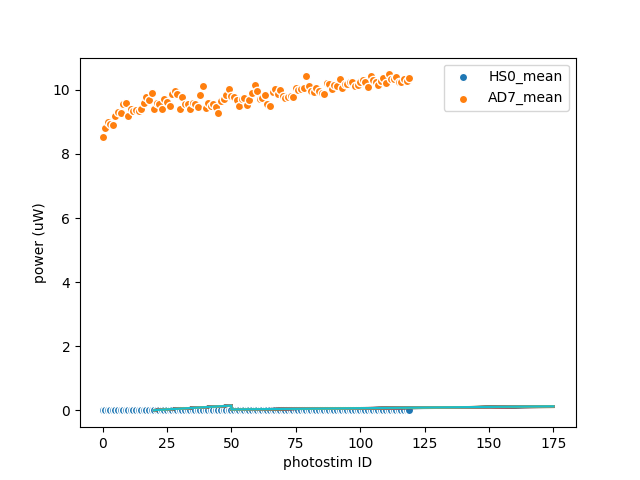

In [43]:
resp_df = ps_dict['response_df']
for ch in ps_dict['measured_channels']:
    col_name = ch+"_mean"
    y = resp_df[col_name]*uW_per_V
    plt.scatter(resp_df['photostim_id'], y, marker='o', edgecolors='white', label=col_name)
    plt.xlabel('photostim ID')
plt.ylabel('power (uW)')
plt.legend()
#plt.ylim([0, np.max(y)*1.1])

In [40]:
ps_dict['i2']

175

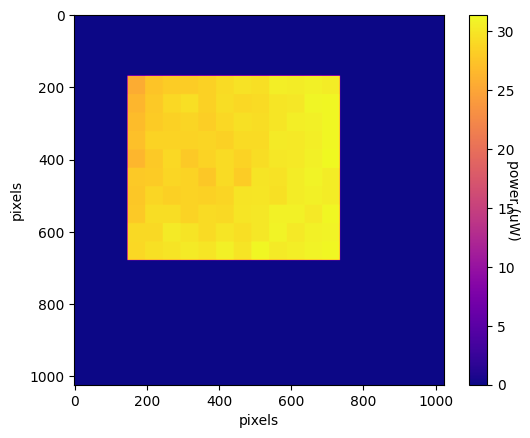

In [22]:
stim_sequence = load_ss_file_from_ps_dict(ps_dict)
sum_img = np.zeros(stim_sequence.image_shape)
i = 0
for resp in y:
    img = stim_sequence.image_sequence[:,:,i] * resp/256
    sum_img+=img
    i += 1
cm = plt.imshow(sum_img, cmap='plasma', vmin=0)
cb = plt.colorbar(cm)
plt.xlabel('pixels')
plt.ylabel('pixels')
cb.set_label('power (uW)', rotation=270)

In [232]:
from collections import OrderedDict
def split_df_by_stimset_sweep(full_df, ss_sweep_trig=0):
    full_df.sort_values(['sweep'], inplace=True)
    ##trig_list is list of indexes where stimset_sweep = trigger (start of new stimset)
    trig_list = full_df.index[full_df['stimset_sweep']==ss_sweep_trig].tolist()
    trig_list.append(len(full_df))
    df_dict = OrderedDict()
    i = 0
    for trig in trig_list[:-1]:
        key = "df_"+str(i)
        df_i = full_df.iloc[trig:trig_list[i+1]]
        df_dict[key] = df_i
        i += 1
    return df_dict

In [237]:
hyperpol_exp_dict = split_df_by_stimset_sweep(hyperpol_df)
hyperpol_exp_dict['df_1']

,baseline_v,min_v,stead_state_v,v_response,tau,tau_r2,sweep,stimset_sweep,time,i_amp
7,-0.067631,-0.133594,-0.132819,-0.065963,0.017851,0.999541,20,0,2024-01-10 11:00:55.740666,-1.300000e-10
8,-0.067636,-0.123563,-0.122817,-0.055927,0.017857,0.999377,21,1,2024-01-10 11:01:02.024000,-1.100000e-10
9,-0.067646,-0.113630,-0.112839,-0.045984,0.017871,0.999051,22,2,2024-01-10 11:01:08.289333,-9.000000e-11
10,-0.067676,-0.103500,-0.102750,-0.035824,0.017854,0.998510,23,3,2024-01-10 11:01:14.590000,-7.000000e-11
11,-0.067650,-0.093469,-0.092710,-0.025819,0.017776,0.996994,24,4,2024-01-10 11:01:20.840000,-5.000000e-11
12,-0.067635,-0.083503,-0.082685,-0.015868,0.017807,0.991737,25,5,2024-01-10 11:01:27.068000,-3.000000e-11
13,-0.067640,-0.073406,-0.072692,-0.005766,0.018000,0.930660,26,6,2024-01-10 11:01:33.346000,-1.000000e-11


In [228]:
trig_list = hyperpol_df.index[hyperpol_df['stimset_sweep']==0].tolist()
df_dict={}
i=0
for trig in trig_list[:-1]:
    key = "df_"+str(i)
    df_i = hyperpol_df.iloc[trig:trig_list[i+1]]
    df_dict[key] = df_i
    i+=1
key = "df_"+str(i)
df_i = hyperpol_df.iloc[trig_list[-1]:]
df_dict[key] = df_i
df_dict
    

{'df_0':    baseline_v     min_v  stead_state_v  v_response       tau    tau_r2  sweep  \
 0   -0.067649 -0.133529      -0.132826   -0.065879  0.017852  0.999534      0   
 1   -0.067655 -0.123464      -0.122825   -0.055809  0.017852  0.999376      1   
 2   -0.067702 -0.113597      -0.112820   -0.045896  0.017815  0.999083      2   
 3   -0.067656 -0.103599      -0.102744   -0.035942  0.017817  0.998474      3   
 4   -0.067654 -0.093502      -0.092722   -0.025848  0.017875  0.997022      4   
 5   -0.067663 -0.083569      -0.082684   -0.015906  0.017915  0.991656      5   
 6   -0.067665 -0.073307      -0.072678   -0.005642  0.018095  0.931855      6   
 
    stimset_sweep                       time         i_amp  
 0              0 2024-01-10 10:58:44.859334 -1.300000e-10  
 1              1 2024-01-10 10:58:51.126000 -1.100000e-10  
 2              2 2024-01-10 10:58:57.423666 -9.000000e-11  
 3              3 2024-01-10 10:59:03.686000 -7.000000e-11  
 4              4 2024-01-10 

In [230]:
trig_list.append(len(hyperpol_df))

In [231]:
trig_list

[0, 7, 14]

In [249]:
rec = PCR_list[6]
sweep = rec.all_meta['notebook']['SweepNum']
stimset_sweep = rec.all_meta['notebook']['Set Sweep Count']
timestamp = rec.start_time
stim = rec.stimulus
i_step_features = features_of_stim_epoch(stim, description='Epoch 1')
i_amp = i_step_features['amplitude']       
i_start = i_step_features['start_time']
i_dur = i_step_features['duration']
v = rec['primary']

In [250]:
hyperpolar_i_inj_sweep(rec, i_start, i_dur)

{'baseline_v': -0.0676653,
 'min_v': -0.07330725,
 'stead_state_v': -0.07267834,
 'v_response': -0.005641952,
 'tau': 0.01809483754098814,
 'tau_r2': 0.9318550791459532,
 'sag': 0.11147045344114304}

In [251]:
i_start

1.03332

In [252]:
pre_step_baseline=0.05
baseline_v = -0.06764938
#response_dict = get_response_time_window(v, start=i_start, dur=i_dur)
min_v = -0.07330725
v_response = -0.005641952
fit_start_v = baseline_v + v_response*0.1
print(fit_start_v)
fit_start_t = find_edges(v.time_slice(i_start, i_start+i_dur), fit_start_v, "falling")
fit_start_t

-0.0682135752


array([1.0348 , 1.03492, 1.035  , 1.03512, 1.0358 ])

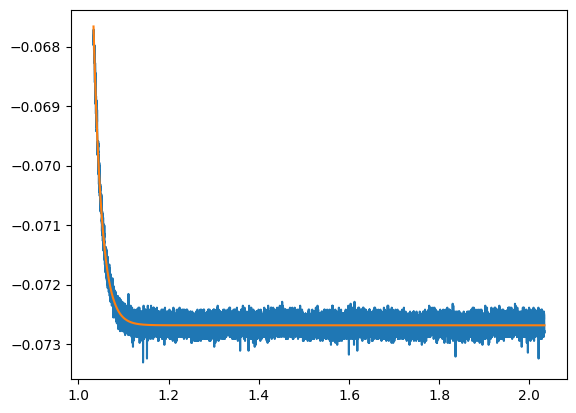

In [253]:
v_sub = v.time_slice(start, start+dur)
popt, pcov = curve_fit(exp_decay, v_sub.time_values, v_sub.data, p0=(0, 0.1, baseline_v, start))
plt.plot(v_sub.time_values, v_sub.data)
#plt.scatter(1.03548, -0.07229)
plt.plot(v_sub.time_values, exp_decay(v_sub.time_values,*popt))
#plt.axis([1,1.1,-0.073, -0.067])

In [215]:
popt

array([-6.26818653e+01,  1.03320296e-01, -7.25918473e-02, -8.44759099e+01])

In [166]:
popt, pcov = curve_fit(exp_decay, sub_v.time_values, sub_v.data, p0=(min_v, 0.1, baseline_v))


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [147]:
find_edges_falling(v.time_slice(i_start,i_start+i_dur), -0.07423315048217774)

array([1.0354])

In [154]:
find_edges(v.time_slice(i_start, i_start+i_dur), -0.074233, edge='el')

AssertionError: value of el invalid for edge argument

In [141]:
def find_edges_falling(TSeries, threshold):
    y = TSeries.data
    t = TSeries.time_values
    falling_edges = np.flatnonzero((y[:-1] > threshold) & (y[1:] < threshold))+1
    return t[falling_edges]

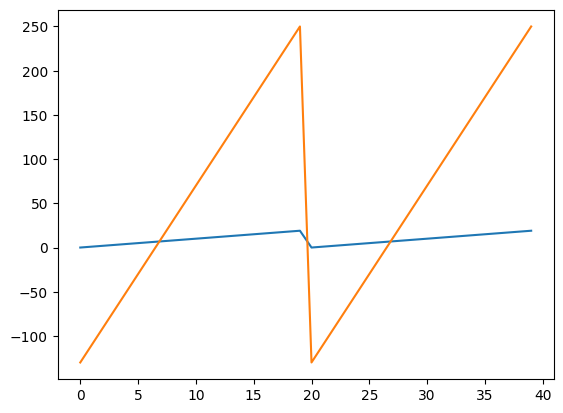

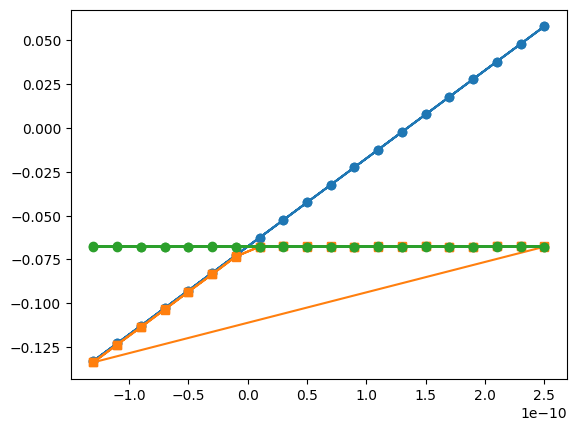

In [111]:
pre_step_window = 0.05
sweeps = []
stimset_sweep = []
timestamps = []
i_amplitudes = []
ss_voltages =[]
min_voltages = []
pre_voltages = []
for rec in PCR_list:
    sweeps.append(rec.all_meta['notebook']['SweepNum'])
    stimset_sweep.append(rec.all_meta['notebook']['Set Sweep Count'])
    timestamps.append(rec.start_time)
    stim = rec.stimulus
    feature_dict = features_of_stim_epoch(stim, description='Epoch 1')
    i_inj = feature_dict['amplitude']
    i_amplitudes.append(i_inj)
    start = feature_dict['start_time']
    dur = feature_dict['duration']
    pri = rec['primary']
    pre_dict = get_response_time_window(pri, start=start-pre_step_window, dur=pre_step_window)
    pre_voltages.append(pre_dict['mean'])
    pre_v = pre_dict['mean']
    response_dict = get_response_time_window(pri, start=start, dur=dur)
    ss_voltages.append(response_dict['steady_state'])
    min_v = response_dict['trough']
    min_voltages.append(min_v)
    v_response = min_v - pre_v
    fit_start_v = pre_v + v_response*0.1
    fit_start_t = np.argmin()
            
    
plt.plot(sweeps, stimset_sweep)
plt.plot(sweeps, np.array(i_amplitudes)*1e12)
plt.show()
plt.plot(i_amplitudes, ss_voltages, marker='o')
plt.plot(i_amplitudes, min_voltages, marker='s')
plt.plot(i_amplitudes, pre_voltages, marker='o')

In [127]:
v=rec['primary']
v.time_slice(start-0.05, start).mean()

-0.06764523

In [121]:
#results={}
sub_d=get_response_time_window(rec['primary'], start=start, dur=dur)
results.update(sub_d)
results

{'mean': 0.055474952,
 'steady_state': 0.057756737,
 'peak': 0.058252398,
 'peak_t': 1.75276,
 'trough': -0.06748574,
 'trough_t': 1.03332}

In [110]:
ts = pri.time_slice(start, start+dur)

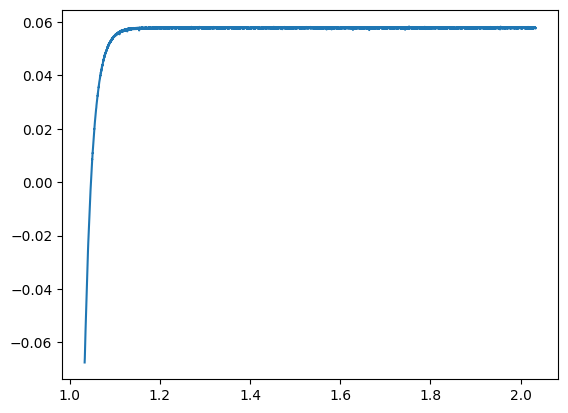

In [113]:
plt.plot(ts.time_values, ts.data)

In [112]:
fit_start_v

-0.06762928068637848

In [118]:
fit_start_t = ts.time_values[np.argmin(ts.data>fit_start_v)]
fit_start_t

1.03332

In [116]:
ts.time_values[17986]

1.75276

(1.75, 1.76, 0.058, 0.0583)

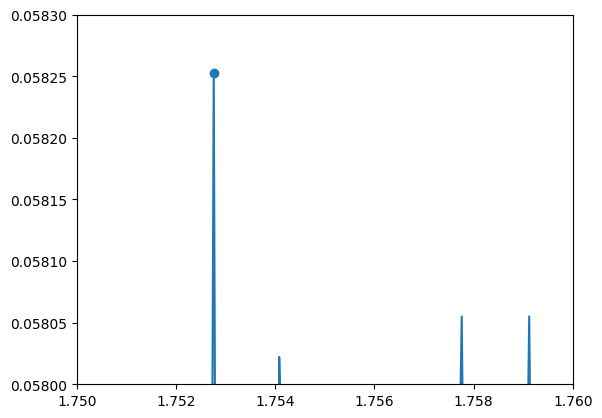

In [93]:
plt.plot(ts.time_values, ts.data)
plt.scatter(1.75276, 0.058252398)
plt.axis([1.75,1.76,0.058,0.0583])

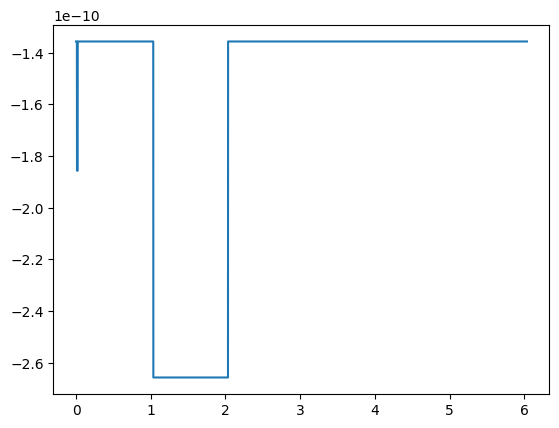

In [39]:
plt.plot(c.time_values, c.data)

In [78]:
start=feature_dict['start_time']
dur = feature_dict['duration']
pri = rec['primary']
np.mean(pri.time_slice(start+dur-0.1, start+dur).data)#start, dur)

0.057758205

In [54]:
for item in rec.stimulus.items:
    print (item.description)
    print (item.amplitude)
    if item.description == 'Epoch 1':
        print (item.amplitude)
        print (item.start_time, item.duration)

holding current
-1.3565332190879076e-10
test pulse
-5.0000004e-11
Epoch 0
0.0
Epoch 1
-1.3e-10
-1.3e-10
1.03332 1.0
Epoch 2
0.0


In [58]:
getattr(item, "start_time")

2.03332

In [61]:
features_of_epoch(rec.stimulus)

{'start_time': 1.03332,
 'duration': 1.0,
 'amplitude': -1.3e-10,
 'type': 'SquarePulse'}

In [57]:
item.start_time

2.03332

In [16]:
SR0 = dataset.contents[0]
SR1 = dataset.contents[1]
SR20 = dataset.contents[20]

In [8]:
SR0.recording_dict

{0: <PatchClampRecording device:0 mode=IC holding=-136>,
 1: <PatchClampRecording device:1 mode=IC holding=-135>}

In [17]:
rec0_0=SR0[0]
rec1_0=SR1[0]
rec20_0 = SR20[0]

In [20]:
rec0_0.stimulus.description

'Isteps1s_DA_0'

In [28]:
rec20_0.start_time

datetime.datetime(2024, 1, 10, 11, 0, 55, 740666)

In [18]:
rec1_0.all_meta

OrderedDict([('start_time',
              datetime.datetime(2024, 1, 10, 10, 58, 51, 126000)),
             ('device_type', 'MultiClamp 700'),
             ('device_id', 0),
             ('notebook',
              OrderedDict([('SweepNum', 1.0),
                           ('TimeStamp', 3787729131.1260004),
                           ('TimeStampSinceIgorEpochUTC', 3787757931.1260004),
                           ('EntrySourceType', 0.0),
                           ('AcquisitionState', 4.0),
                           ('TP Baseline Vm', None),
                           ('TP Baseline pA', None),
                           ('TP Peak Resistance', None),
                           ('TP Steady State Resistance', None),
                           ('Fast compensation capacitance', None),
                           ('Slow compensation capacitance', None),
                           ('Fast compensation time', None),
                           ('Slow compensation time', None),
                    